**Introduction**

This Kaggle competition involves classifying whether a given tweet is about a real disaster or not. 

This is a binary classification problem where the goal is to build a model that can accurately distinguish disaster-related tweets from non-disaster tweets.

**Data overview**

The dataset consists of tweets labeled as either 1 (disaster) or 0 (not disaster). The primary features include the text of the tweet, and optional data like location and keyword. 

Each row contains a tweet’s text and some rows also have associated data like location or specific keywords.

**Size**

The dataset includes 10876 tweets, 7613 entries for train data and 3263 entries for test data. That's a split of 70% / 30%.

**Structure**

Each data point includes a tweet's text and its label. 

**NLP relevance**

The challenge emphasizes Natural Language Processing techniques to process and classify textual data.





**Importing libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam 
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping 

**Exploratory Data Analysis**

In [4]:
train_data = pd.read_csv(r"C:\Users\anne-\OneDrive\Documents\Colorado Boulder\Introduction to Deep Learning\Week4 Disaster Tweets\train.csv")
test_data = pd.read_csv(r"C:\Users\anne-\OneDrive\Documents\Colorado Boulder\Introduction to Deep Learning\Week4 Disaster Tweets\test.csv")

print(train_data.columns)
print(test_data.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [6]:
print(train_data.head())
print(train_data.info())
print(test_data.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'

In [4]:
print(train_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Out of 7613 entries, 61 have no keyword and 2533 have no location. This will not impact our analysis since we're going to focus on the text information.

<Axes: xlabel='target', ylabel='count'>

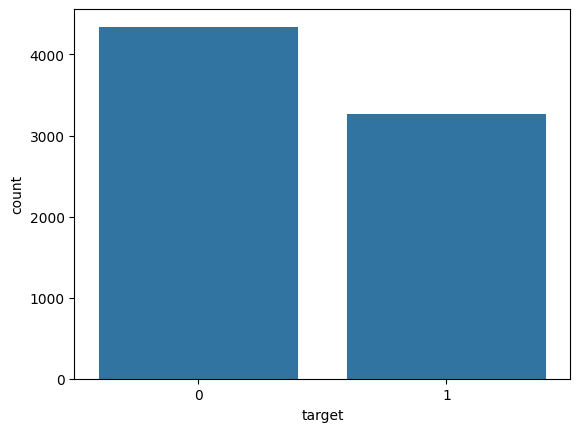

In [5]:
sns.countplot(data = train_data, x = "target")

There is a significant class imbalance, with a lot less actual disaster tweets (label = 1). 

**Visualization of most common words with WordCloud**

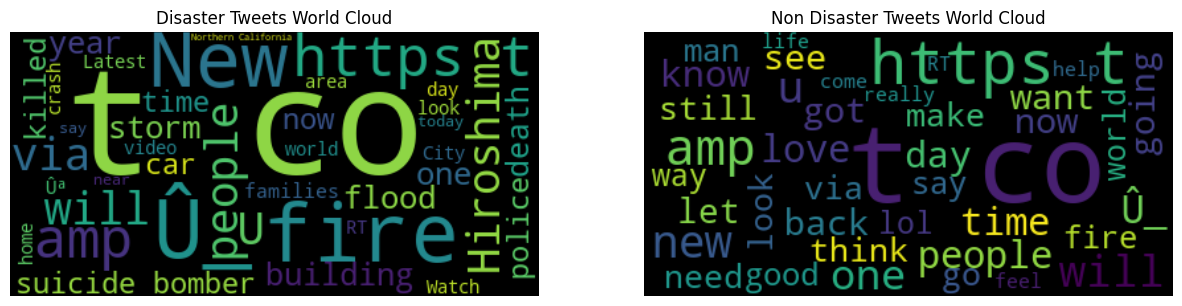

In [6]:
disaster_tweets = train_data[train_data["target"] == 1]["text"].values
non_disaster_tweets = train_data[train_data["target"] == 0]["text"].values

word_cloud_disaster = WordCloud(max_words = 40).generate(" ".join(disaster_tweets))
word_cloud_non_disaster = WordCloud(max_words = 40).generate(" ".join(non_disaster_tweets))

plt.figure(figsize = (15,30))

plt.subplot(1, 2, 1)
plt.imshow(word_cloud_disaster, interpolation = "bilinear")
plt.title("Disaster Tweets World Cloud")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(word_cloud_non_disaster, interpolation = "bilinear")
plt.title("Non Disaster Tweets World Cloud")
plt.axis("off")

plt.show()

**Data Cleaning**

In [8]:
import re
import nltk
from nltk.corpus import stopwords

def text_cleaning(text) :
    text = re.sub(r"http\S+","", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words("english")]
    text = " ".join(text)
    return text
    
train_data["cleaned_text"] = train_data["text"].apply(text_cleaning)
test_data["cleaned_text"] = test_data["text"].apply(text_cleaning)

In [8]:
print(train_data[["text", "cleaned_text"]].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  people receive wildfires evacuation orders cal...  
4  got sent photo ruby alaska smoke wildfires pou...  


**Model Architecture**

In [9]:
tokenizer = Tokenizer(num_words = 5000, lower = True)
tokenizer.fit_on_texts(train_data["cleaned_text"])

X = tokenizer.texts_to_sequences(train_data["cleaned_text"])
X = pad_sequences(X, maxlen = 50)

y= train_data["target"].values

LSTM Model
We are going to use a LSTM model for our analysis.

In [10]:
def build_model(hp) :

    model = Sequential()
    
    model.add(Input(shape = (X.shape[1],)))
    
    model.add(Embedding(
        input_dim = 5000, 
        output_dim = hp.Int("embedding_dim", 20, 200, 20)
    ))
    
    model.add(SpatialDropout1D(
        hp.Float("spatial_dropout", 0.1, 0.5, 0.1)))
    
    model.add(LSTM(
        units = hp.Int("lstm_units", 20, 200, 20),
        dropout = hp.Float("lstm_dropout", 0.1, 0.5, 0.1),
        recurrent_dropout = hp.Float("recurrent_dropout", 0.1, 0.5, 0.1)
    ))
    
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(
        optimizer = Adam(
            learning_rate = hp.Float("learning_rate", 1e-6, 1e-3, sampling = "LOG")
        ),
        loss = "binary_crossentropy", metrics = ["accuracy"]
    )

    return model

**Bayesian optimization with Kfold cross validation and early stopping**

In [11]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
fold_nb = 1
val_scores = []
early_stop = EarlyStopping(monitor = "val_loss", patience = 2, verbose = 1, mode = "min")

for train_index, val_index in kfold.split(X, y):
    print(f"Training on fold {fold_nb}...")
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    tuner = kt.BayesianOptimization(
        build_model,
        objective = "val_accuracy",
        max_trials = 10,
        directory = f"tuner_dir_fold_{fold_nb}",
        project_name = "Disaster_Tweets"
    )
    
    tuner.search(
        X_train_fold, y_train_fold,
        epochs = 8,
        validation_data = (X_val_fold, y_val_fold),
        callbacks = [early_stop],
        batch_size = 8,
        verbose = 2
    )
    
    best_model = tuner.get_best_models(num_models = 1)[0]

    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)
    
    val_scores.append(val_accuracy)

    print(f"Validation accuracy for fold {fold_nb}: {val_accuracy: .4f}")

    best_model.save(f"Disaster_Tweets_best_model_fold_{fold_nb}.keras")
    
    fold_nb +=1
        

Training on fold 1...
Reloading Tuner from tuner_dir_fold_1\Disaster_Tweets\tuner0.json



c:\Users\anne-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8299 - loss: 0.4149
Validation accuracy for fold 1:  0.8129
Training on fold 2...
Reloading Tuner from tuner_dir_fold_2\Disaster_Tweets\tuner0.json
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8124 - loss: 0.4522
Validation accuracy for fold 2:  0.8063
Training on fold 3...
Reloading Tuner from tuner_dir_fold_3\Disaster_Tweets\tuner0.json
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8188 - loss: 0.4652
Validation accuracy for fold 3:  0.8227
Training on fold 4...
Reloading Tuner from tuner_dir_fold_4\Disaster_Tweets\tuner0.json
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8146 - loss: 0.4491
Validation accuracy for fold 4:  0.8081
Training on fold 5...
Reloading Tuner from tuner_dir_fold_5\Disaster_Tweets\tuner0.json
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8082 - loss: 0.4635
Validation accuracy for fold 5:  0.8075


In [ ]:
mean_val_accuracy = np.mean(val_scores)
print(f"Mean validation accuracy across all folds: {mean_val_accuracy:.4f}")

Mean validation accuracy across all folds: 0.8115

**Summary and conclusion**

The model provides consistent validation accuracies across all five folds, ranging from approximately 0.8075 to 0.8227. 

The mean validation accuracy across all folds is 0.8115.

The model demonstrates stable performance across different subsets of the data. 

So, our LSTM model with the chosen hyperparameters generalizes well to unseen data, making it a reliable choice for our tweet classification task.

In [10]:
from keras.models import load_model
loaded_model = load_model("Disaster_Tweets_best_model_v9.keras")

c:\Users\anne-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
X_test = tokenizer.texts_to_sequences(test_data["cleaned_text"])
X_test = pad_sequences(X_test, maxlen = 50)

predictions = loaded_model.predict(X_test)
predicted_classes = (predictions > 0.5).astype("int32")

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


In [21]:
np.savetxt("predicted_classes_v9.txt", predicted_classes, delimiter = ",")
print(len(predicted_classes))

3263


**Conclusion**

Accuracy on test is 0.80, and ranking on Kaggle leaderboard is 461/938. 

Our model is stable and performs well.

But we can continue later the hyperparameter tuning to see if accuracy can be improved further.